# Линейная регрессия. Практика

Итак, набор данных содержит следующие столбцы:

age — возраст страхователя;

sex — пол;

bmi — индекс массы тела (кг/м^2), в идеале — от 18.5 до 24.9;

children — количество детей, охваченных медицинской страховкой;

smoker — является ли человек курящим;

region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);

charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [249]:
#Импорты

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [250]:
data = pd.read_csv('data/insurance.csv')
display(data.head())
display(data.info())
display(data.describe())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [251]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

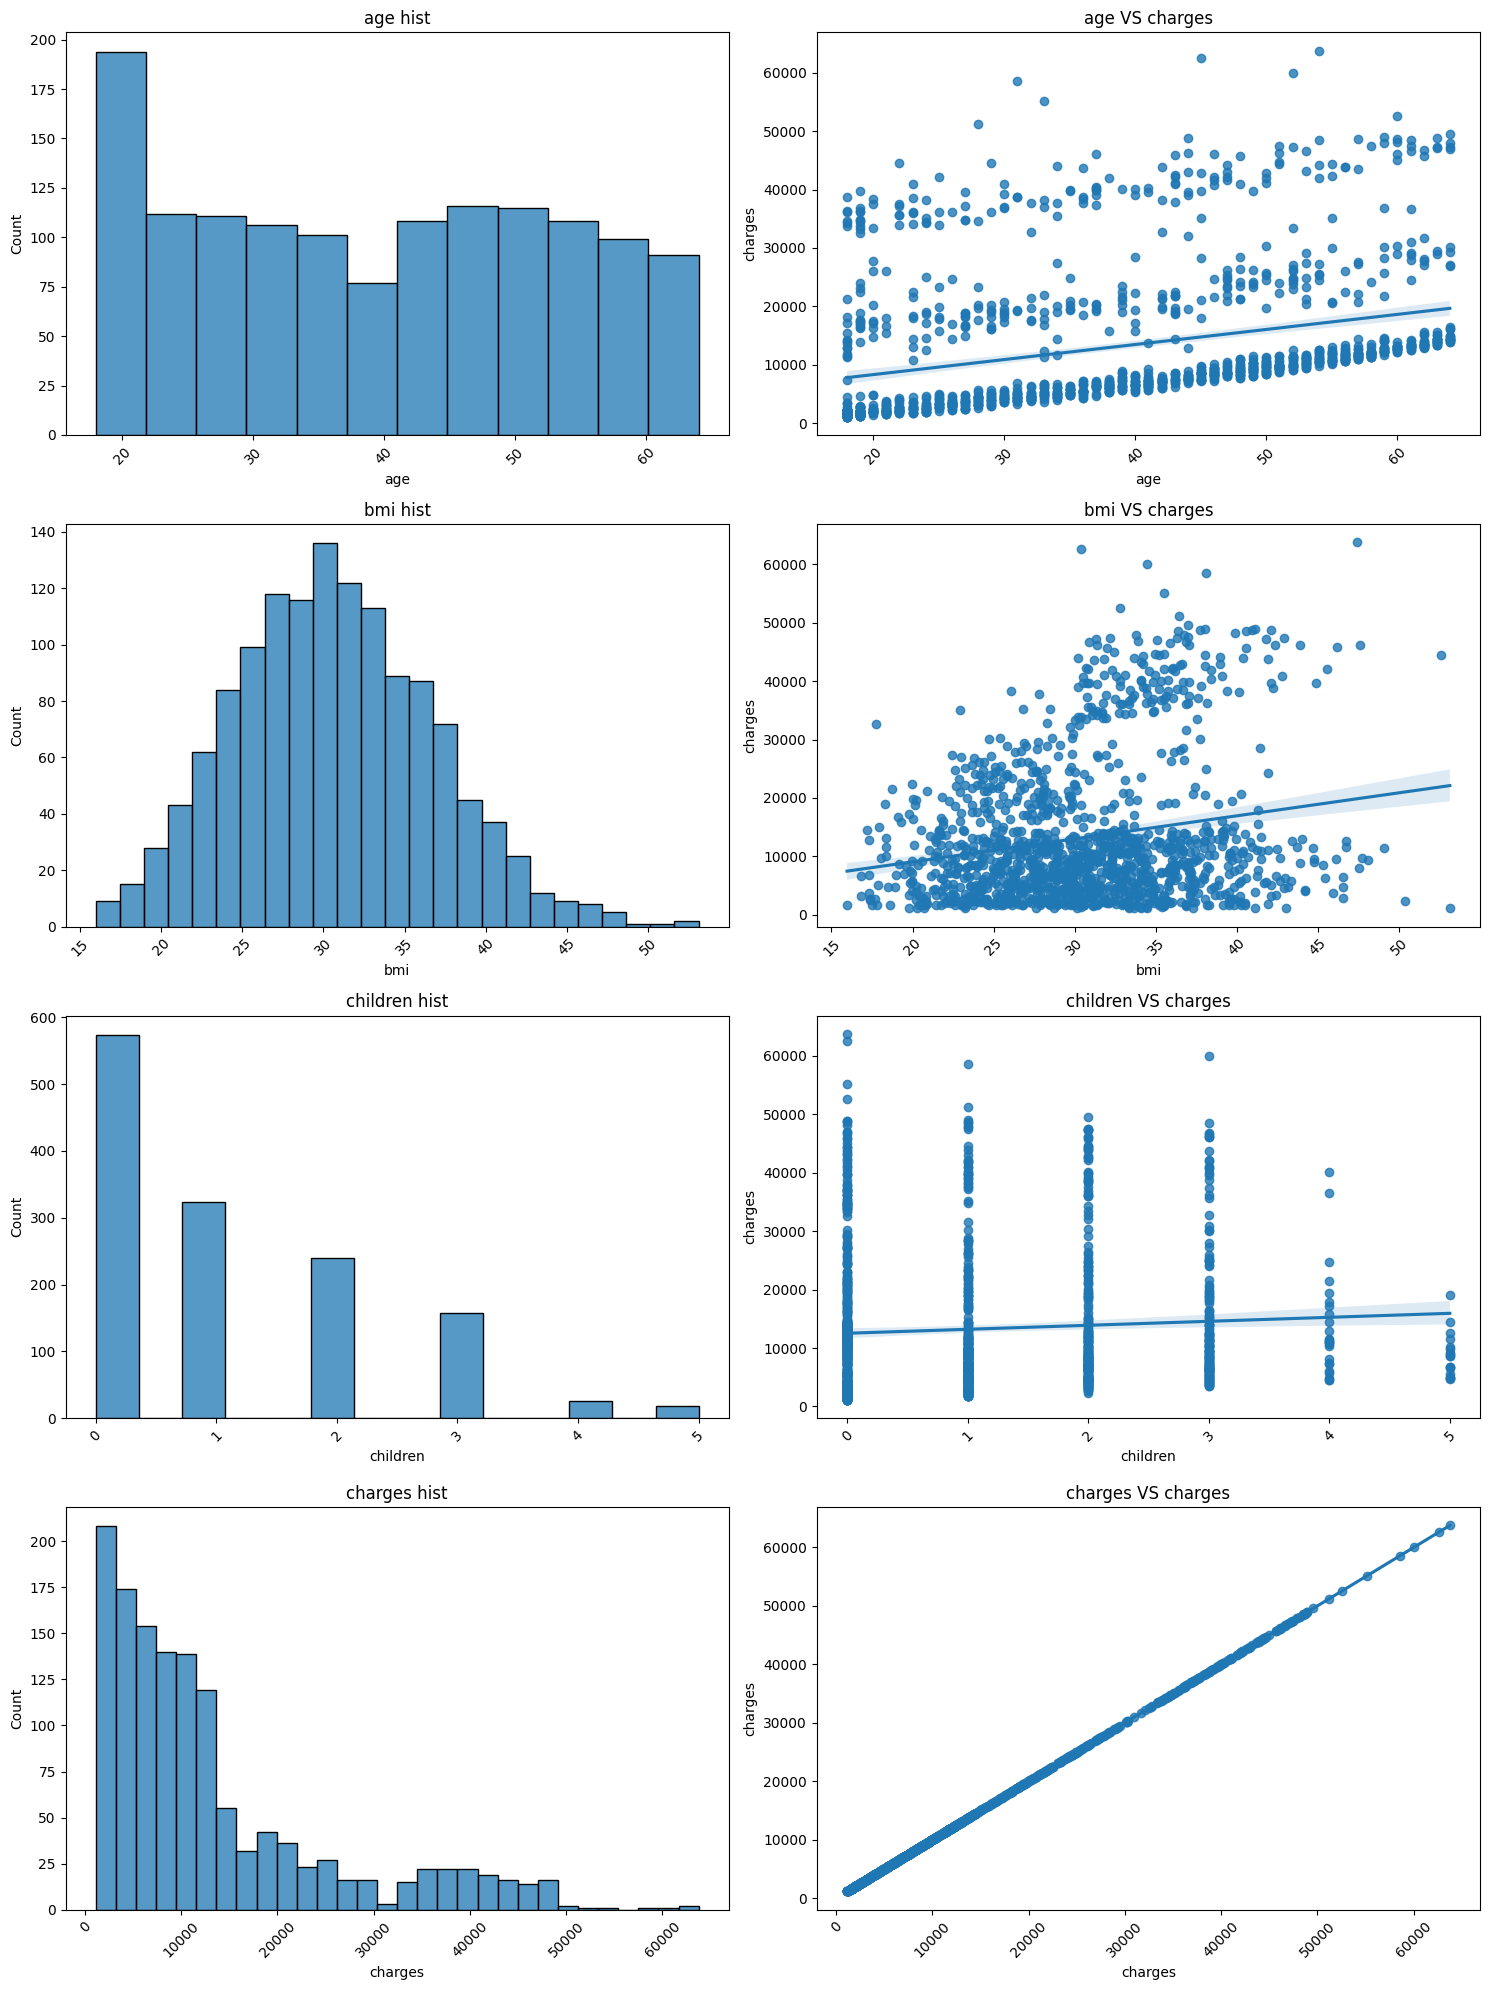

In [252]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [253]:
display(data['region'].value_counts())
display(data.describe(include='object'))

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [254]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


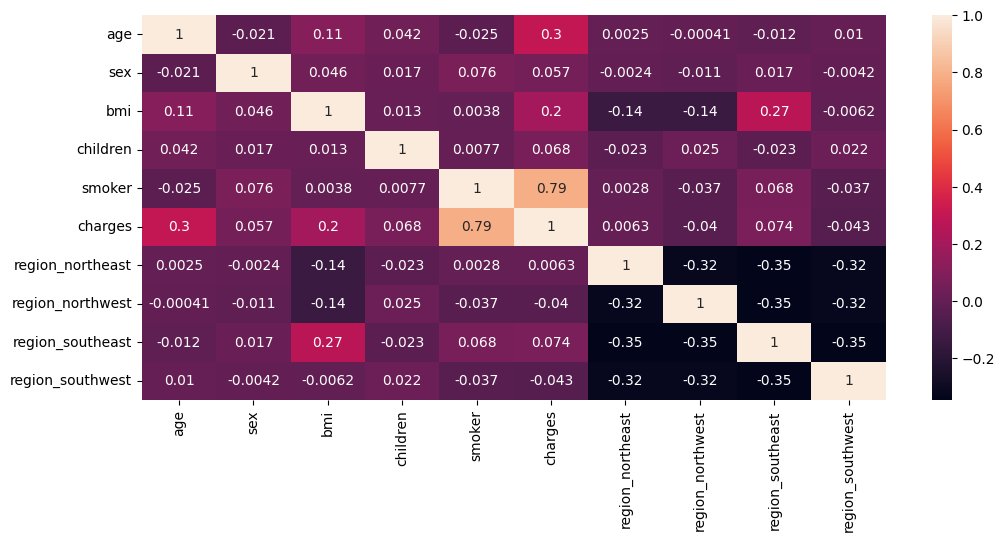

In [255]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data.corr(), annot=True);

In [256]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [257]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [258]:
#Задание 6.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_test.shape)

#Задание 6.2

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
display(round(model.intercept_, 2))

#Задание 6.3
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

(268, 9)

-12390.8

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Test MAPE: 47


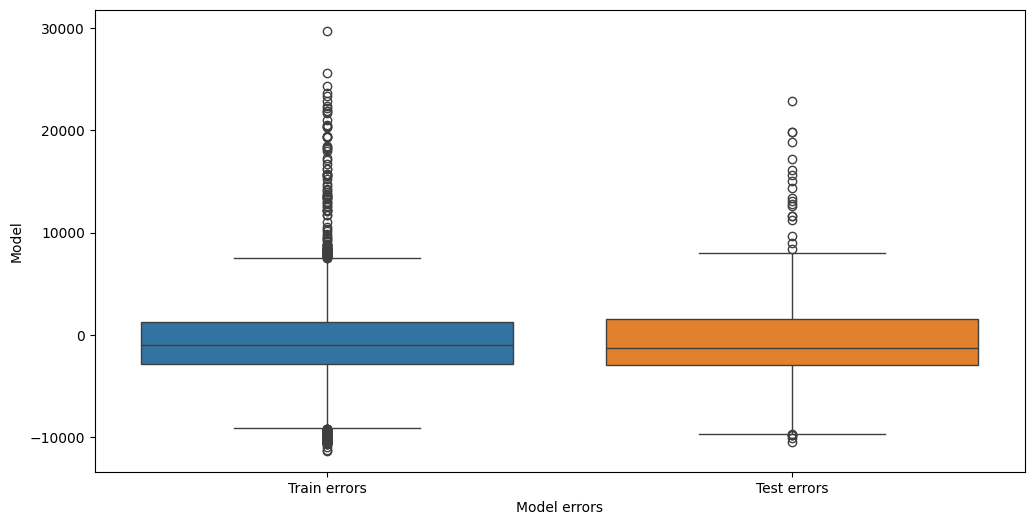

In [259]:
#Задание 6.4

#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_predict
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_predict
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [260]:
# Задание 6.5

mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

polynomiazer = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
polynomiazer.fit(X_train_scaled)
X_train_scaled_poly = polynomiazer.transform(X_train_scaled)
X_test_scaled_poly = polynomiazer.transform(X_test_scaled)

display(X_test_scaled_poly.shape)

(268, 54)

In [261]:
#Задание 6.6

model_scaled_poly = linear_model.LinearRegression()
model_scaled_poly.fit(X_train_scaled_poly, y_train)

y_train_scaled_poly_predict = model_scaled_poly.predict(X_train_scaled_poly)
y_test_scaled_poly_predict = model_scaled_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_scaled_poly_predict, y_test, y_test_scaled_poly_predict)

#Задание 6.7

model_scaled_poly.coef_ #надо регулировать, значения высокие

Train R^2: 0.842
Train MAE: 2900
Train MAPE: 29


Test R^2: 0.866
Test MAE: 2738
Test MAPE: 30


array([-1.13531659e+16,  1.49551785e+17,  3.07335590e+15,  2.17845129e+15,
       -2.31555321e+15, -7.48548434e+16, -2.14706424e+16, -3.33851147e+16,
       -4.12829097e+16,  8.40200000e+03,  8.95500000e+02,  9.45000000e+02,
       -1.69950000e+03,  1.25000000e+02,  1.13531659e+16,  1.13531659e+16,
        1.13531659e+16,  1.13531659e+16, -1.26551938e+17,  6.53187500e+02,
       -1.25843750e+03,  2.38937500e+02, -2.29998473e+16, -2.29998473e+16,
       -2.29998473e+16, -2.29998473e+16, -9.67801562e+03,  1.69831250e+03,
        5.48468438e+04, -3.07335590e+15, -3.07335590e+15, -3.07335590e+15,
       -3.07335590e+15, -2.04000000e+03, -2.16800000e+03, -2.17845129e+15,
       -2.17845129e+15, -2.17845129e+15, -2.17845129e+15,  9.27918574e+15,
       -6.96363253e+15, -6.96363253e+15, -6.96363253e+15, -6.96363253e+15,
       -7.61875083e+14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.41460761e+16,  0.00000000e+00,  0.00000000e+00, -4.22316038e+16,
        0.00000000e+00, -

In [262]:
#Задание 6.8

l1_Lasso_lr = linear_model.Lasso(max_iter=2000)
l1_Lasso_lr.fit(X_train_scaled_poly, y_train)
y_train_scaled_poly_predict_l1 = l1_Lasso_lr.predict(X_train_scaled_poly)
y_test_scaled_poly_predict_l1 = l1_Lasso_lr.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_scaled_poly_predict_l1, y_test, y_test_scaled_poly_predict_l1)
l1_Lasso_lr.coef_

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2719
Test MAPE: 30


array([ 3.24221653e+03, -4.92313816e+02,  5.07612317e+03,  4.58362056e+03,
        1.97928569e+03,  1.88025707e+02, -4.70775218e+02,  5.83657101e+02,
       -2.43543456e+02,  8.29826751e+03,  7.74581954e+02,  8.44448593e+02,
       -1.20775688e+03,  1.34809915e+02, -1.04309726e+03, -0.00000000e+00,
        1.16964229e+03,  1.61765564e+03, -0.00000000e+00,  5.05847740e+02,
       -1.13425152e+03,  2.65796922e+02, -1.22240479e+03,  0.00000000e+00,
        2.36213242e+02, -5.80031340e+02, -8.17963257e+03,  1.29487768e+03,
        5.47148553e+04,  3.58531873e+03,  2.40690210e+03, -9.63549427e+02,
        0.00000000e+00, -1.67464337e+03, -2.05436459e+03,  1.94204864e+03,
        1.95394442e+03, -0.00000000e+00, -1.06364416e+03,  8.00606774e+00,
        5.93688978e+02, -0.00000000e+00, -2.30643423e+02,  1.97933477e+03,
        6.31615519e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [263]:
#Задание 6.9

l2_ridge_lr = linear_model.Ridge()
l2_ridge_lr.fit(X_train_scaled_poly, y_train)
y_train_scaled_poly_predict_l2 = l2_ridge_lr.predict(X_train_scaled_poly)
y_test_scaled_poly_predict_l2 = l2_ridge_lr.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_scaled_poly_predict_l2, y_test, y_test_scaled_poly_predict_l2)
l2_ridge_lr.coef_

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Test MAPE: 31


array([ 3369.38386245,  -457.59604061,  3655.82413935,  3198.89989857,
        2682.62197133,   199.05715111,  -228.717235  ,   191.94660928,
        -162.28652539,  7548.51142058,   581.66782381,   935.50427948,
        -681.52086519,   663.45387027,  -450.92174702,   438.63623056,
        1406.72601433,  1974.94336458,  -457.59604061,   947.62267378,
        -902.74408745,   739.02044241,  -822.63208356,   302.52583364,
         351.60830856,  -289.09809926, -4274.11806366,  2734.55631801,
       44541.21377368,  3667.33801864,  1719.64618126, -1249.79159857,
        -481.36846198, -1314.96604775, -2172.72264458,  2171.5603185 ,
        1997.18187938,   112.64828732, -1082.49058663,  2682.62197133,
          94.23317954,  -208.05994804,   535.71682279,  2260.73191704,
         199.05715111,     0.        ,     0.        ,     0.        ,
        -228.717235  ,     0.        ,     0.        ,   191.94660928,
           0.        ,  -162.28652539])

c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


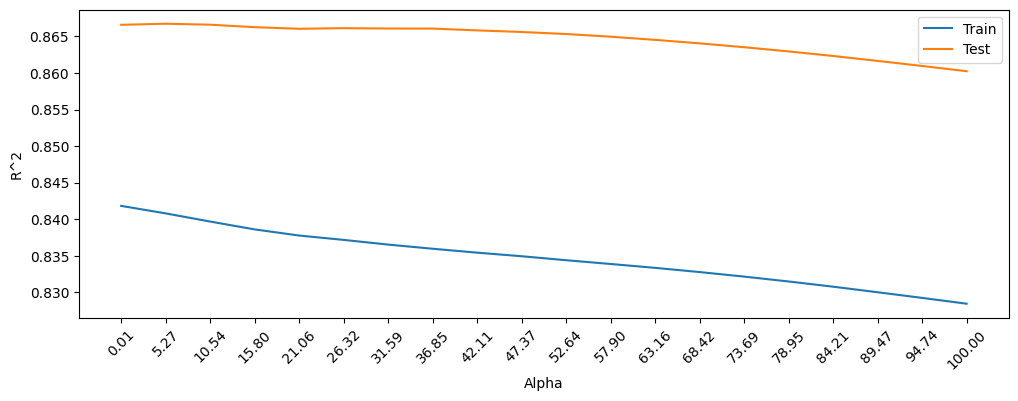

In [264]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.01, 100, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    l1_Lasso_lr = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    l1_Lasso_lr.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = l1_Lasso_lr.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = l1_Lasso_lr.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))
    
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

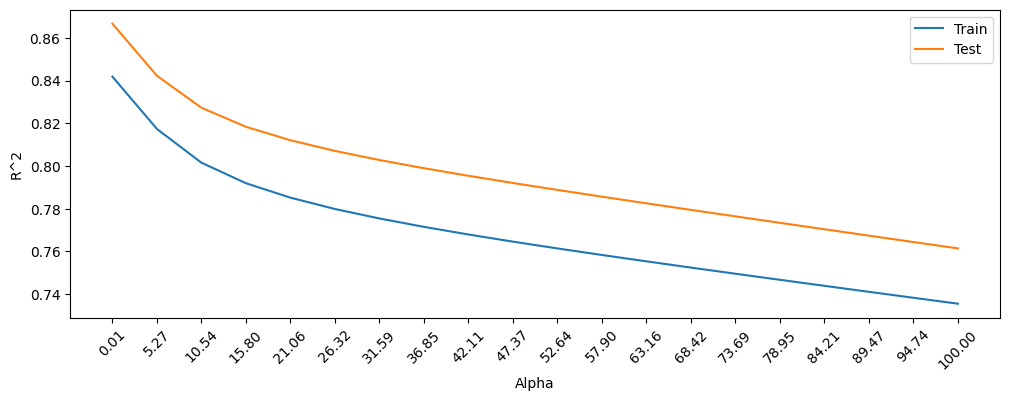

In [265]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.01, 100, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L2-регуляризацией
    l2_ridge_lr = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель
    l2_ridge_lr.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = l2_ridge_lr.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = l2_ridge_lr.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))
    
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды